In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib
import plotly
import matplotlib.pyplot as plt
import plotly.offline as pyoff
import plotly.graph_objs as go
from datetime import datetime, timedelta

# Ajuste nos dados Fiscais

In [2]:
# Carrega os dados fiscais
df_fiscal = pd.read_excel('RESUMO FISCAL.xlsx')

In [3]:
# Visualizando os dados iniciais
df_fiscal.head()

,cp_tipo_linha,ctrl_grupo,linha_ajuste,quebra_pagina,row_dados,linha_rel,resumo,zebra,empresa,tipo_inscricao,...,base_calculo_c_protege,aliquota_protege,valor_imposto_protege,acrescimos_protege,outras_deducoes_protege,saldo_credor_anterior_protege,saldo_diferido_anterior_protege,imposto_a_recolher_protege,imposto_diferido_protege,saldo_credor_protege
0,1,0,0,0,NaN,1,NaN,1,FARMACIA,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,0,NaN,2,NaN,0,FARMACIA,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,0,NaN,3,NaN,1,FARMACIA,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0,0,NaN,4,NaN,0,FARMACIA,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0,0,NaN,5,NaN,1,FARMACIA,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Função para limpar e organizar os dados
def ajuste_fiscal(df_fiscal):
    
    # Ajustando o Iss
    df_iss = df_fiscal.copy()
    df_iss = df_iss[['competencia','imposto_a_recolher_l', 'imposto_l']].rename(columns= {
    'imposto_a_recolher_l': 'valor','imposto_l': 'natureza_operacao'})
    df_iss['competencia'] = df_iss['competencia'].fillna(method = 'ffill')
    df_iss['competencia'] = df_iss['competencia'].fillna(method = 'bfill')
    df_iss.dropna(subset = ['valor'], inplace=True)
    
    # Ajustando o Pis/Cofins
    df_pis_cofins = df_fiscal.copy()
    df_pis_cofins = df_pis_cofins[['competencia','imposto_a_recolher_c','imposto_c',]].rename(columns= {
        'imposto_a_recolher_c': 'valor', 'imposto_c': 'natureza_operacao',})
    df_pis_cofins['competencia'] = df_pis_cofins['competencia'].fillna(method = 'ffill')
    df_pis_cofins['competencia'] = df_pis_cofins['competencia'].fillna(method = 'bfill')
    df_pis_cofins.dropna(subset = ['valor'], inplace=True)
    
    # Ajustando os dados de faturamento fiscal
    df_faturamento_fiscal = df_fiscal.copy()
    df_faturamento_fiscal = df_faturamento_fiscal[['competencia','pis_cofins_base_calculo']].rename(columns= {'pis_cofins_base_calculo': 'valor'})
    df_faturamento_fiscal['competencia'] = df_faturamento_fiscal['competencia'].fillna(method = 'ffill')
    df_faturamento_fiscal['competencia'] = df_faturamento_fiscal['competencia'].fillna(method = 'bfill')
    df_faturamento_fiscal.dropna(subset = ['valor'], inplace=True)
    df_faturamento_fiscal['natureza_operacao'] = 'Faturamento'
    df_faturamento_fiscal.drop_duplicates(subset=['competencia'], inplace=True)
    
    #Concatenação e formatação final
    df_fiscal_final = pd.concat([df_iss,df_pis_cofins,df_faturamento_fiscal],ignore_index=True)
    df_fiscal_final['competencia'] = pd.to_datetime(df_fiscal_final['competencia'])
    df_fiscal_final['competencia'] = df_fiscal_final['competencia'].dt.strftime('%m/%d/%Y')
    df_fiscal_final['natureza_operacao'] = df_fiscal_final['natureza_operacao'].str.capitalize()
    df_fiscal_final = df_fiscal_final.query('valor != 0.00')
    df_fiscal_final.rename(columns={'competencia': 'Competencia','valor':'Valor','natureza_operacao':'Natureza_Operacao'}, inplace=True)
    
    return df_fiscal_final

In [5]:
# Chamada a função
df_fiscal_final = ajuste_fiscal(df_fiscal)

In [6]:
# Visualizando uma amostra do Resultado 
df_fiscal_final.sample(10)

,Competencia,Valor,Natureza_Operacao
55,01/10/2020,13141.0038,Iss
240,01/04/2022,4121.3500,Pis
173,01/03/2020,11487.6000,Cofins
226,01/11/2021,5045.5300,Pis
247,01/06/2020,595752.9700,Faturamento
184,01/07/2020,6026.0100,Pis
211,01/05/2021,25144.1700,Cofins
30,01/06/2020,23433.7000,Icms
200,01/01/2021,4615.6300,Pis
196,01/12/2020,4171.9600,Pis


### Evolução do Faturamento Mensal

In [7]:
# Copia dos dados tratados
df_indic = df_fiscal_final.copy()

In [8]:
# Gerando relatório de faturamento
df_indic_fatu = df_indic.query('Natureza_Operacao == "Faturamento"')
df_indic_fatu['CrescimentoMensal'] = df_indic_fatu['Valor'].pct_change()*100
df_indic_fatu.head()

,Competencia,Valor,Natureza_Operacao,CrescimentoMensal
242,01/01/2020,940375.77,Faturamento,NaN
243,01/02/2020,935145.20,Faturamento,-0.556221
244,01/03/2020,425466.85,Faturamento,-54.502590
245,01/04/2020,726554.74,Faturamento,70.766475
246,01/05/2020,728978.71,Faturamento,0.333625


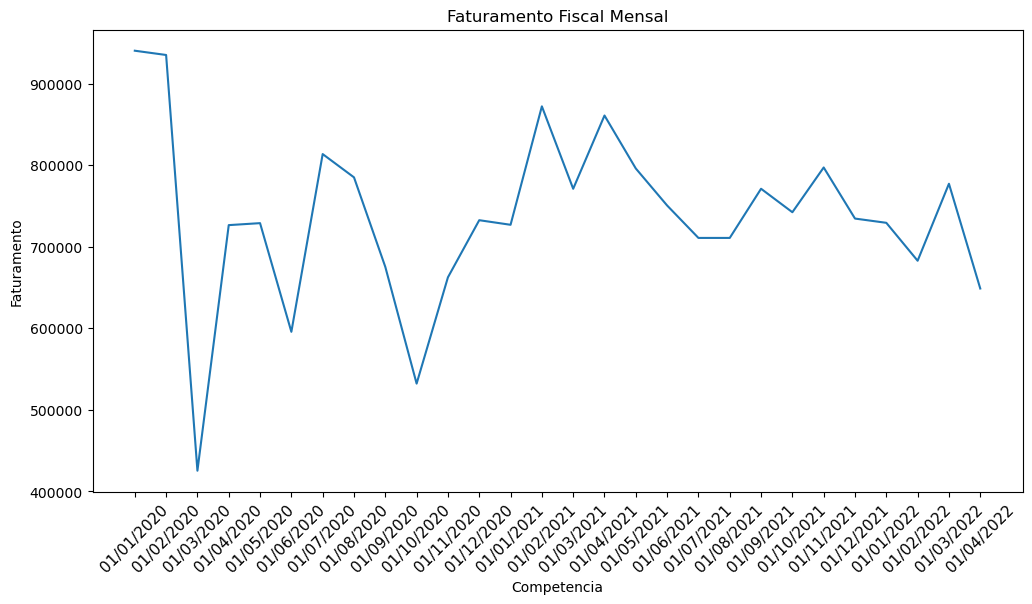

In [9]:
# Gráfico
plt.figure(figsize = (12, 6))
plt.rcParams['xtick.labelsize'] = 11
plt.xticks(rotation=45)
sns.lineplot(data=df_indic_fatu, x="Competencia", y="Valor")
plt.ylabel('Faturamento')
plt.title('Faturamento Fiscal Mensal')
plt.show()

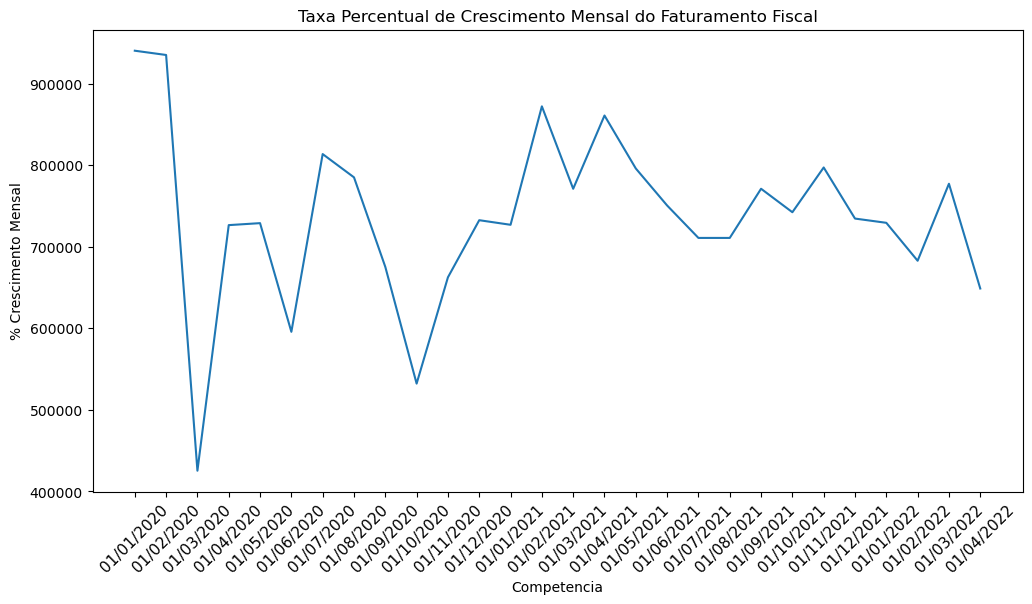

In [10]:
# Gráfico
plt.figure(figsize = (12, 6))
plt.rcParams['xtick.labelsize'] = 11
plt.xticks(rotation=45)
sns.lineplot(data=df_indic_fatu, x="Competencia", y="Valor")
plt.ylabel('% Crescimento Mensal')
plt.title('Taxa Percentual de Crescimento Mensal do Faturamento Fiscal')
plt.show()

### Evolução do Valor da guia de Cofins

In [11]:
# Prepara os dados
df_indic_trib = df_indic.query('Natureza_Operacao == "Cofins"')
df_indic_trib['CrescimentoMensal'] = df_indic_trib['Valor'].pct_change()*100
df_indic_trib.head()

,Competencia,Valor,Natureza_Operacao,CrescimentoMensal
169,01/01/2020,25390.15,Cofins,NaN
171,01/02/2020,25248.90,Cofins,-0.556318
173,01/03/2020,11487.60,Cofins,-54.502572
177,01/04/2020,21132.33,Cofins,83.957746
179,01/05/2020,21092.66,Cofins,-0.187722


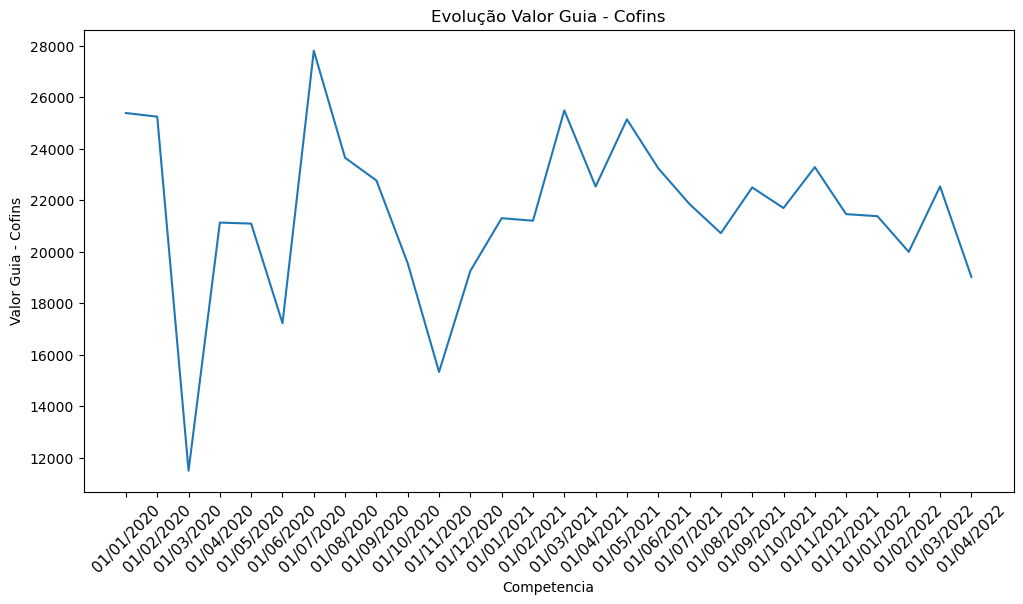

In [12]:
# Gráfico
plt.figure(figsize = (12, 6))
plt.rcParams['xtick.labelsize'] = 11
plt.xticks(rotation=45)
sns.lineplot(data=df_indic_trib, x="Competencia", y="Valor")
plt.ylabel('Valor Guia - Cofins')
plt.title('Evolução Valor Guia - Cofins')
plt.show()

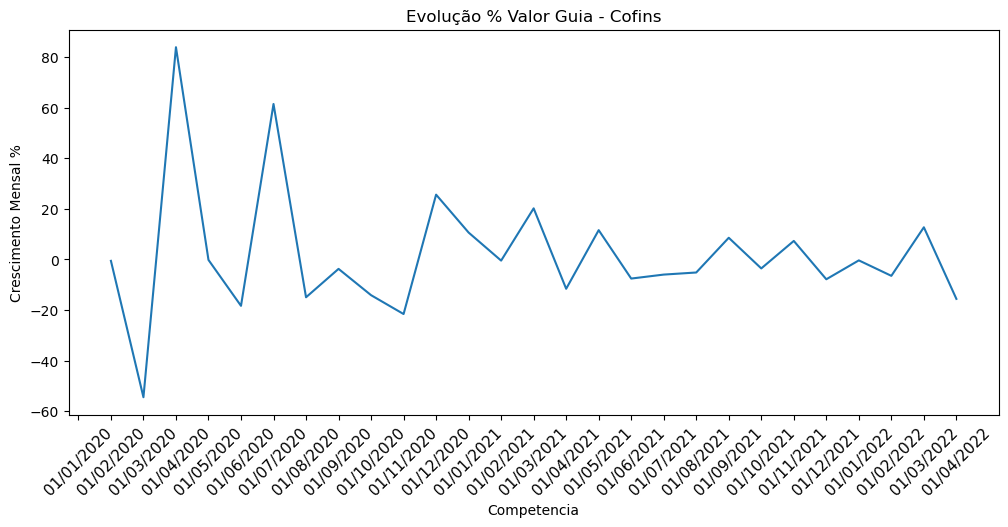

In [13]:
# Gráfico
plt.figure(figsize = (12, 5))
plt.rcParams['xtick.labelsize'] = 11
plt.xticks(rotation=45)
sns.lineplot(data=df_indic_trib, x="Competencia", y="CrescimentoMensal")
plt.ylabel('Crescimento Mensal %')
plt.title('Evolução % Valor Guia - Cofins')
plt.show()

### Evolução do Valor da guia de ISS

In [14]:
# Prepara os dados
df_indic_trib2 = df_indic.query('Natureza_Operacao == "Iss"')
df_indic_trib2['CrescimentoMensal'] = df_indic_trib2['Valor'].pct_change()*100
df_indic_trib2.head()

,Competencia,Valor,Natureza_Operacao,CrescimentoMensal
1,01/01/2020,25181.58,Iss,NaN
7,01/02/2020,18105.59,Iss,-28.099865
13,01/03/2020,11363.24,Iss,-37.239052
19,01/04/2020,15153.50,Iss,33.355451
25,01/05/2020,14102.35,Iss,-6.936681


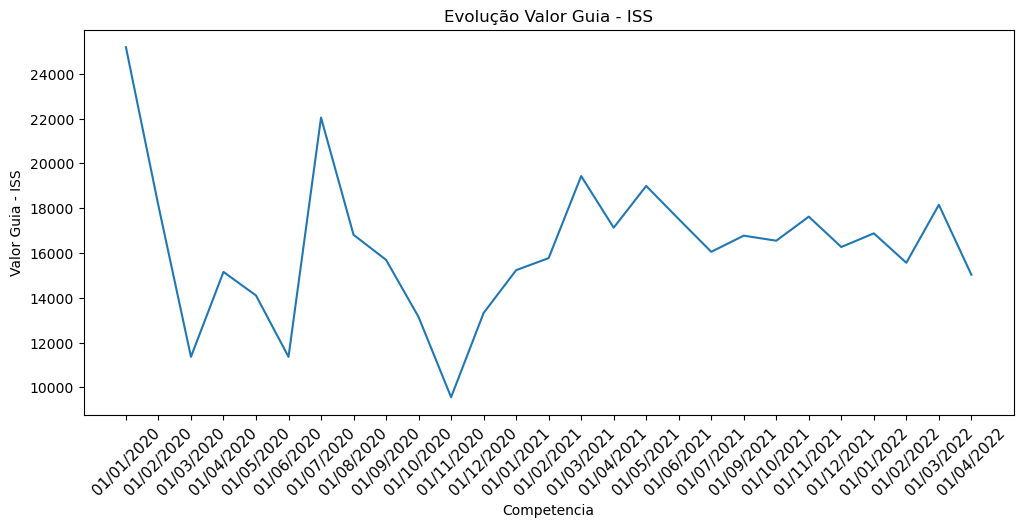

In [15]:
# Gráfico
plt.figure(figsize = (12, 5))
plt.rcParams['xtick.labelsize'] = 11
plt.xticks(rotation=45)
sns.lineplot(data=df_indic_trib2, x="Competencia", y="Valor")
plt.ylabel('Valor Guia - ISS')
plt.title('Evolução Valor Guia - ISS')
plt.show()

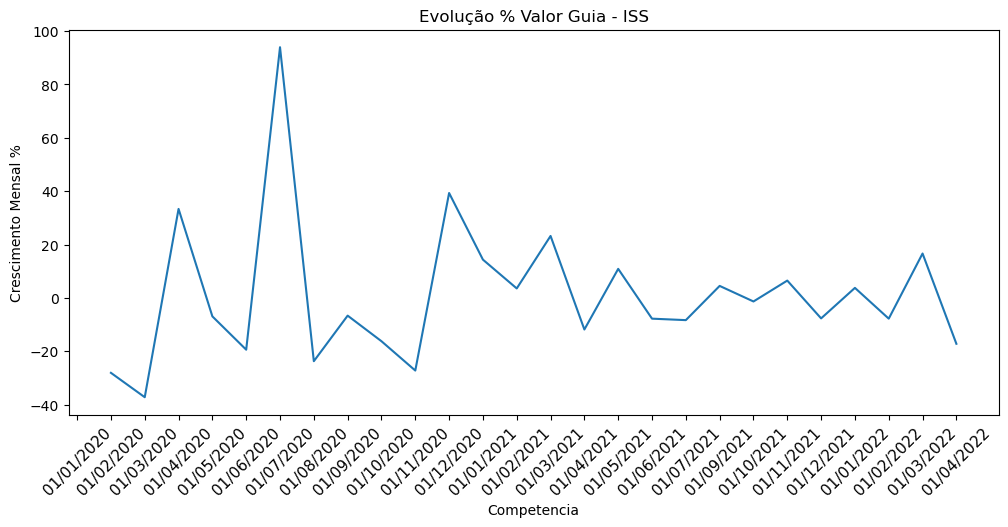

In [16]:
# Gráfico
plt.figure(figsize = (12, 5))
plt.rcParams['xtick.labelsize'] = 11
plt.xticks(rotation=45)
sns.lineplot(data=df_indic_trib2, x="Competencia", y="CrescimentoMensal")
plt.ylabel('Crescimento Mensal %')
plt.title('Evolução % Valor Guia - ISS')
plt.show()

# Ajuste nos dados Contabéis

In [17]:
# Carrega os dados fiscais
df_contabil = pd.read_excel('DRE DETALHADA.xlsx')

In [18]:
# Visualizando os dados iniciais
df_contabil.head()

,demonstrativo,sequencia,clascta,nomeemp,nomcont,crccont,respon,cargo,datafin,dataini,...,ctgruposdre_tipo,emissao,insc_jcom,data_jcom,texto_lucro,texto_prejuizo,codigo,titulo_dre,titulo_dre_segunda_linha,titulo_dra
0,1,1,4.1.1.01,FARMACIA,FELIPE NOGUEIRA,XXXXXX,FELIPE NOGUEIRA,NÃO INFORMADO,31/12/2021,01/01/2021,...,T,"21/06/2022 19:06:25,181264",XXXX,05/07/2001,LUCRO LÍQUIDO DO EXERCÍCIO,PREJUÍZO DO EXERCÍCIO,4,NaN,NaN,NaN
1,1,1,4.1.1.01.0001,FARMACIA,FELIPE NOGUEIRA,XXXXXX,FELIPE NOGUEIRA,NÃO INFORMADO,31/12/2021,01/01/2021,...,T,"21/06/2022 19:06:25,181264",XXXX,05/07/2001,LUCRO LÍQUIDO DO EXERCÍCIO,PREJUÍZO DO EXERCÍCIO,4,NaN,NaN,NaN
2,1,1,4.1.1.03,FARMACIA,FELIPE NOGUEIRA,XXXXXX,FELIPE NOGUEIRA,NÃO INFORMADO,31/12/2021,01/01/2021,...,T,"21/06/2022 19:06:25,181264",XXXX,05/07/2001,LUCRO LÍQUIDO DO EXERCÍCIO,PREJUÍZO DO EXERCÍCIO,4,NaN,NaN,NaN
3,1,1,4.1.1.03.0001,FARMACIA,FELIPE NOGUEIRA,XXXXXX,FELIPE NOGUEIRA,NÃO INFORMADO,31/12/2021,01/01/2021,...,T,"21/06/2022 19:06:25,181264",XXXX,05/07/2001,LUCRO LÍQUIDO DO EXERCÍCIO,PREJUÍZO DO EXERCÍCIO,4,NaN,NaN,NaN
4,1,2,4.1.2.02,FARMACIA,FELIPE NOGUEIRA,XXXXXX,FELIPE NOGUEIRA,NÃO INFORMADO,31/12/2021,01/01/2021,...,T,"21/06/2022 19:06:25,181264",XXXX,05/07/2001,LUCRO LÍQUIDO DO EXERCÍCIO,PREJUÍZO DO EXERCÍCIO,3,NaN,NaN,NaN


In [19]:
def ajusta_contabil(df_contabil):
    
    # ajustando as contas de Custo e Despesa
    df_contabil_contas = df_contabil.copy()
    df_contabil_contas = df_contabil_contas[['datafin', 'nomegrupo', 'nomeconta', 'valor', 'saldo_anterior']].rename\
    (columns= {'datafin':'competencia', 'nomeconta':'nome_conta', 'nomegrupo':'nome_grupo', 'valor':'valor_conta', 
               'saldo_anterior':'ano_anterior'}) 
    df_contabil_contas = df_contabil_contas[(df_contabil_contas['valor_conta']!= 0) | (df_contabil_contas['ano_anterior'] != 0)]
    
    # Ajustando as contas de Resultado
    df_contabil_grupos = df_contabil.copy()
    df_contabil_grupos = df_contabil_grupos[['datafin','nomegrupo', 'valorgrupo', 'valorgrupoant']].rename\
    (columns= {'datafin':'competencia','nomegrupo':'nome_conta','valorgrupo':'valor_conta', 'valorgrupoant':'ano_anterior'})
    df_contabil_grupos['nome_grupo'] = df_contabil_grupos['nome_conta']
    df_contabil_grupos = df_contabil_grupos
    df_contabil_grupos = df_contabil_grupos[(df_contabil_grupos['valor_conta'] != 0) | (df_contabil_grupos['ano_anterior'] != 0)]
    
    #Concatenação e formatação final
    df_contabil_final = pd.concat([df_contabil_contas,df_contabil_grupos],ignore_index=True)
    df_contabil_final.rename(columns={'competencia': 'Competencia','nome_grupo':'Grupo de Contas',
                                      'nome_conta':'Conta','valor_conta':'Ano Atual',
                                      'ano_anterior':'Ano Anterior'}, inplace=True)
    
    return df_contabil_final

In [20]:
# Chamada a função
df_contabil_final = ajusta_contabil(df_contabil)

In [21]:
# Visualizando uma amostra do Resultado
df_contabil_final.sample(10)

,Competencia,Grupo de Contas,Conta,Ano Atual,Ano Anterior
42,31/12/2021,DESPESAS GERAIS,MANUTENÇÃO E REPARO,-83095.04,-19895.00
14,31/12/2021,DESPESAS COM PESSOAL,INSS,-180493.94,-212058.37
4,31/12/2021,(-) DEDUÇÕES,(-) ISS,-201833.92,-185678.67
32,31/12/2021,DESPESAS GERAIS,SERVIÇOS DE CONSULTORIA,0.00,-16142.56
54,31/12/2021,OUTRAS RECEITAS/DESPESAS OPERACIONAIS,RETORNO DE SEGURO,0.00,17452.58
49,31/12/2021,IMPOSTOS E CONTRIBUIÇÕES,TAXAS DIVERSAS,-67993.32,-25.64
56,31/12/2021,(=) RECEITA LÍQUIDA,(=) RECEITA LÍQUIDA,7921070.53,7901247.77
5,31/12/2021,(-) DEDUÇÕES,(-) ICMS,-448754.81,-386786.00
59,31/12/2021,(=) RESULTADO LÍQUIDO,(=) RESULTADO LÍQUIDO,3299457.83,1619041.40
36,31/12/2021,DESPESAS GERAIS,LANÇHES E REFEIÇÕES,-1054.58,0.00


### Criando uma DRE (Demosntração do Resultado)

In [22]:
# Verifica o grupo de contas
df_contabil_final['Grupo de Contas'].unique()

array(['RECEITA BRUTA', '(-) DEDUÇÕES',
       'CUSTO DA MERCADORIA/PRODUTO/SERVIÇO', 'DESPESAS COM PESSOAL',
       'DESPESAS GERAIS', 'IMPOSTOS E CONTRIBUIÇÕES',
       'OUTRAS DESPESAS ADMINISTRATIVAS', 'DESPESAS FINANCEIRAS',
       'RECEITAS FINANCEIRAS', 'OUTRAS RECEITAS/DESPESAS OPERACIONAIS',
       'PROVISÃO PARA IRPJ E CSLL', '(=) RECEITA LÍQUIDA',
       '(=) LUCRO BRUTO', '(=) RESULTADO ANTES DO EFEITO FINANCEIRO',
       '(=) RESULTADO LÍQUIDO', '(=) RESULTADO ANTES DO IRPJ E CSLL',
       '(=) RESULTADO LÍQUIDO DO EXERCÍCIO'], dtype=object)

In [23]:
# Cria um dicionário para organizar as contas na estrutura da DRE
ordenacao = {'RECEITA BRUTA':1,'(-) DEDUÇÕES':2,'(=) RECEITA LÍQUIDA':3, 'CUSTO DA MERCADORIA/PRODUTO/SERVIÇO':4,
 '(=) LUCRO BRUTO':5,'DESPESAS COM PESSOAL':6, 'DESPESAS GERAIS':7,'OUTRAS DESPESAS ADMINISTRATIVAS':8,
             'IMPOSTOS E CONTRIBUIÇÕES':9,'(=) RESULTADO ANTES DO EFEITO FINANCEIRO':10,'RECEITAS FINANCEIRAS':11, 
             'DESPESAS FINANCEIRAS':12, 'OUTRAS RECEITAS/DESPESAS OPERACIONAIS':13,'(=) RESULTADO ANTES DO IRPJ E CSLL':14,
             'PROVISÃO PARA IRPJ E CSLL':15,'(=) RESULTADO LÍQUIDO DO EXERCÍCIO':16}

In [24]:
# Cria um dicionário para organizar as contas na estrutura da DRE
ajuste_nome = {'RECEITA BRUTA':'(+)RECEITA BRUTA','(-) DEDUÇÕES':'(-) DEDUÇÕES','(=) RECEITA LÍQUIDA':'(=) RECEITA LÍQUIDA', 
               'CUSTO DA MERCADORIA/PRODUTO/SERVIÇO':'(-)CUSTO DA MERCADORIA/PRODUTO/SERVIÇO',
               '(=) LUCRO BRUTO':5,'DESPESAS COM PESSOAL':6, 'DESPESAS GERAIS':7,'OUTRAS DESPESAS ADMINISTRATIVAS':8,
             'IMPOSTOS E CONTRIBUIÇÕES':9,'(=) RESULTADO ANTES DO EFEITO FINANCEIRO':10,'RECEITAS FINANCEIRAS':11, 
             'DESPESAS FINANCEIRAS':12, 'OUTRAS RECEITAS/DESPESAS OPERACIONAIS':13,'(=) RESULTADO ANTES DO IRPJ E CSLL':14,
             'PROVISÃO PARA IRPJ E CSLL':15,'(=) RESULTADO LÍQUIDO DO EXERCÍCIO':16}

In [25]:
# Formata a DRE e cria uma coluna de crescimento ou redução em relação ao ano anterior
df_contabil_Rel = df_contabil_final.groupby(['Grupo de Contas']).sum(['Ano Anterior','Ano Anterior']).reset_index()
df_contabil_Rel['Ordem_conta'] = df_contabil_Rel['Grupo de Contas'].map(ordenacao)
df_contabil_Rel = df_contabil_Rel.sort_values(by='Ordem_conta', ascending=True)
df_contabil_Rel = df_contabil_Rel.query('Ordem_conta >0')
df_contabil_Rel.drop(columns='Ordem_conta', inplace=True)
df_contabil_Rel.rename(columns={'Ano Atual':2022, 'Ano Anterior':2021}, inplace=True)
df_contabil_Rel['Crescimento/Redução'] = round(df_contabil_Rel[2022] - df_contabil_Rel[2021],2)
df_contabil_Rel['%Crescimento/Redução'] = round(df_contabil_Rel['Crescimento/Redução'] / df_contabil_Rel[2021],4)*100
df_contabil_Rel['%Crescimento/Redução'].replace([np.inf, -np.inf], 0, inplace=True)
df_contabil_Rel['%Crescimento/Redução'] = round(df_contabil_Rel['%Crescimento/Redução'],2).astype('str') + '%'

In [26]:
df_contabil_Rel

,Grupo de Contas,2022,2021,Crescimento/Redução,%Crescimento/Redução
15,RECEITA BRUTA,8900686.88,8750724.33,149962.55,1.71%
0,(-) DEDUÇÕES,-979616.35,-849476.56,-130139.79,15.32%
2,(=) RECEITA LÍQUIDA,7921070.53,7901247.77,19822.76,0.25%
7,CUSTO DA MERCADORIA/PRODUTO/SERVIÇO,-2052561.42,-4188948.75,2136387.33,-51.0%
1,(=) LUCRO BRUTO,5868509.11,3712299.02,2156210.09,58.08%
8,DESPESAS COM PESSOAL,-919490.39,-1241771.69,322281.30,-25.95%
10,DESPESAS GERAIS,-1508634.48,-784445.96,-724188.52,92.32%
12,OUTRAS DESPESAS ADMINISTRATIVAS,-131.73,-100.00,-31.73,31.73%
11,IMPOSTOS E CONTRIBUIÇÕES,-109022.61,-21786.39,-87236.22,400.42%
3,(=) RESULTADO ANTES DO EFEITO FINANCEIRO,3331229.90,1664194.98,1667034.92,100.17%


#### Gerando o % de lucro Liquido sobre a receita liquida

In [27]:
# Gerando o percentual de lucro liquido sobre a receita liquida
df_contabil_luc = df_contabil_final[['Conta','Ano Atual','Ano Anterior']].copy()
df_contabil_luc = df_contabil_luc.query('Conta =="(=) RESULTADO LÍQUIDO DO EXERCÍCIO" \
                                       | Conta =="(=) RECEITA LÍQUIDA"')
df_contabil_luc = df_contabil_luc.groupby(['Conta']).sum(['Ano Atual','Ano Anterior'])
df_contabil_luc.rename(columns={'Ano Atual':2022, 'Ano Anterior':2021}, inplace=True)
df_contabil_luc = df_contabil_luc.T
df_contabil_luc.rename(columns={'Conta':'Periodo','(=) RECEITA LÍQUIDA': 'RECEITA LÍQUIDA',
                               '(=) RESULTADO LÍQUIDO DO EXERCÍCIO':'RESULTADO LÍQUIDO'}, inplace=True)
df_contabil_luc['% Lucro'] = round(100*df_contabil_luc['RESULTADO LÍQUIDO'] /
                                   df_contabil_luc['RECEITA LÍQUIDA']-1,2).astype('str') + '%'
print(df_contabil_luc)

Conta  RECEITA LÍQUIDA  RESULTADO LÍQUIDO % Lucro
2022        7921070.53         3038257.26  37.36%
2021        7901247.77         1390971.67   16.6%


#### Analisando detalhadamente a conta de DESPESAS COM PESSOAL com que reduziu em 25,95%

In [28]:
# Prepara os dados
df_contabil_fol = df_contabil_final.copy()
df_contabil_fol.rename(columns={'Grupo de Contas':'Grupo_Contas'}, inplace=True)
df_contabil_fol = df_contabil_fol.query('Grupo_Contas== "DESPESAS COM PESSOAL"')
df_contabil_fol = df_contabil_fol.groupby(['Grupo_Contas','Conta']).sum(['Ano Atual','Ano Anterior'])
df_contabil_fol.rename(columns={'Ano Atual':2022, 'Ano Anterior':2021}, inplace=True)
df_contabil_fol['Crescimento/Redução'] = round(df_contabil_fol[2022] - df_contabil_fol[2021],2)
df_contabil_fol['%Crescimento/Redução'] = round(df_contabil_fol['Crescimento/Redução'] / df_contabil_fol[2021],4)*100
df_contabil_fol['%Crescimento/Redução'].replace([np.inf, -np.inf], 0, inplace=True)
df_contabil_fol['%Crescimento/Redução'] = round(df_contabil_fol['%Crescimento/Redução'],2).astype('str') + '%'

In [29]:
df_contabil_fol

2022       2021  \
Grupo_Contas         Conta                                                     
DESPESAS COM PESSOAL 13º SALARIO                        -44814.88  -53522.47   
                     ASSISTENCIA MEDICA E ODONTOLOGICA  -19689.07  -32607.13   
                     CURSOS E TREINAMENTOS                   0.00  -48000.00   
                     FGTS                               -63164.73  -64812.90   
                     FÉRIAS                             -76974.79  -46702.58   
                     INDENIZAÇÕES TRABALHISTAS           -1575.64   -4630.34   
                     INSS                              -180493.94 -212058.37   
                     PRO-LABORE                         -26400.00  -25044.00   
                     SALARIOS E ORDENADOS              -501575.56 -713215.78   
                     TRANSPORTE                           -699.93  -41178.12   
                     UNIFORMES                           -4101.85       0.00   

                                                        Crescimento/Redução  \
Grupo_Contas         Conta                                                    
DESPESAS COM PESSOAL 13º SALARIO                                    8707.59   
                     ASSISTENCIA MEDICA E ODONTOLOGICA             12918.06   
                     CURSOS E TREINAMENTOS                         48000.00   
                     FGTS                                           1648.17   
                     FÉRIAS                                       -30272.21   
                     INDENIZAÇÕES TRABALHISTAS                      3054.70   
                     INSS                                          31564.43   
                     PRO-LABORE                                    -1356.00   
                     SALARIOS E ORDENADOS                         211640.22   
                     TRANSPORTE                                    40478.19   
                     UNIFORMES                                     -4101.85   

                                                       %Crescimento/Redução  
Grupo_Contas         Conta                                                   
DESPESAS COM PESSOAL 13º SALARIO                                    -16.27%  
                     ASSISTENCIA MEDICA E ODONTOLOGICA              -39.62%  
                     CURSOS E TREINAMENTOS                          -100.0%  
                     FGTS                                            -2.54%  
                     FÉRIAS                                          64.82%  
                     INDENIZAÇÕES TRABALHISTAS                      -65.97%  
                     INSS                                           -14.88%  
                     PRO-LABORE                                       5.41%  
                     SALARIOS E ORDENADOS                           -29.67%  
                     TRANSPORTE                                      -98.3%  
                     UNIFORMES                                         0.0%

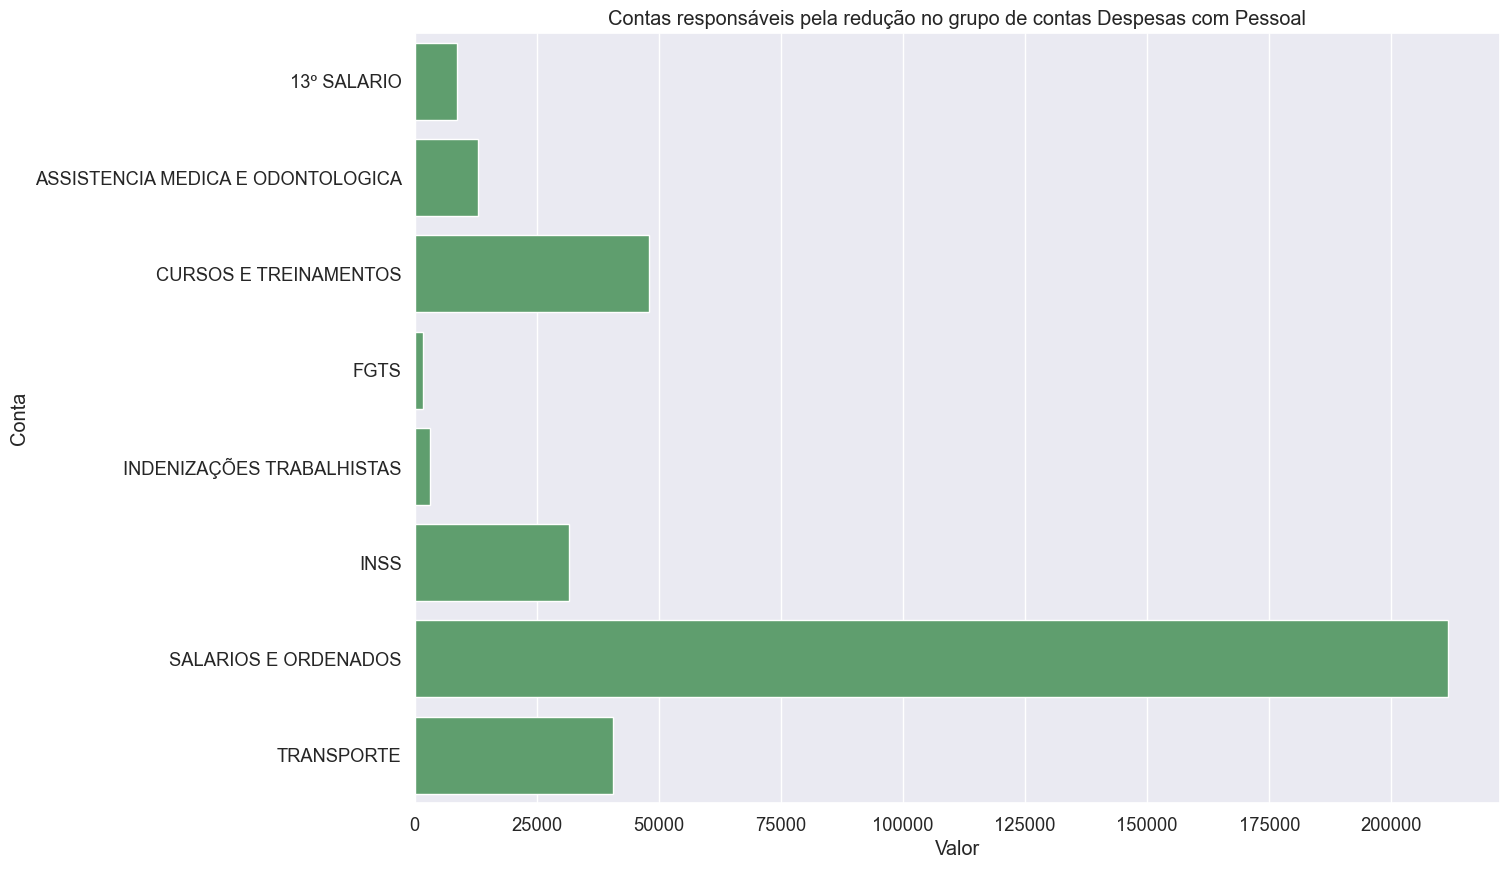

In [30]:
# Gráfico
sns.set(font_scale = 1.2)
plt.figure(figsize = (14,10))
df_ajus = df_contabil_fol.rename(columns={'Crescimento/Redução':'Cresc_Red'},inplace=True)
df_ajus = df_contabil_fol.query('Cresc_Red >0').reset_index()
sns.barplot(x = df_ajus['Cresc_Red'], y = df_ajus['Conta'],
            color = 'g')
plt.title("Contas responsáveis pela redução no grupo de contas Despesas com Pessoal")
plt.xlabel('Valor')
plt.show()

#### Analisando detalhadamente a conta de DESPESAS GERAIS com que aumentou em 92,32%

In [31]:
# Prepara os dados
df_contabil_ger = df_contabil_final.copy()
df_contabil_ger.rename(columns={'Grupo de Contas':'Grupo_Contas'}, inplace=True)
df_contabil_ger = df_contabil_ger.query('Grupo_Contas== "DESPESAS GERAIS"')
df_contabil_ger = df_contabil_ger.groupby(['Grupo_Contas','Conta']).sum(['Ano Atual','Ano Anterior'])
df_contabil_ger.rename(columns={'Ano Atual':2022, 'Ano Anterior':2021}, inplace=True)
df_contabil_ger['Crescimento/Redução'] = round(df_contabil_ger[2021] - df_contabil_ger[2022],2)
df_contabil_ger['%Crescimento/Redução'] = round( df_contabil_ger[2021]/df_contabil_ger['Crescimento/Redução'],4)*100
df_contabil_ger['%Crescimento/Redução'].replace([np.inf, -np.inf], 0, inplace=True)
df_contabil_ger['%Crescimento/Redução'] = round(df_contabil_ger['%Crescimento/Redução'],2).astype('str') + '%'

In [32]:
df_contabil_ger

2022       2021  \
Grupo_Contas    Conta                                                      
DESPESAS GERAIS ACORDO JUDICIAL                          0.00   -9666.29   
                AGUA E ESGOTO                       -17261.41  -16649.55   
                ALUGUEL DE MAQUINAS E EQUIPAMENTOS       0.00   -1230.90   
                ALUGUEL E CONDOMINIO               -323259.79 -227102.51   
                ASSOCIAÇÕES E SINDICATOS                 0.00   -2148.99   
                BENS DE PEQUENO VALOR                  -40.00       0.00   
                CARTORIO                             -3947.56       0.00   
                DEPRECIAÇÃO E AMORTIZAÇÃO           -18796.95  -23639.07   
                ENERGIA ELETRICA                   -146071.37 -108053.76   
                GASTOS COM CARTÃO DE CREDITO       -171523.71  -53997.88   
                HONORARIOS CONTABEIS                -67310.16 -118125.60   
                HONORARIOS JURIDICOS                     0.00  -16541.09   
                HOSPEDAGEM (SITE E E-MAIL)               0.00   -3466.19   
                LANÇHES E REFEIÇÕES                  -1054.58       0.00   
                MANUTENÇÃO E REPARO                 -83095.04  -19895.00   
                MATERIA DE ESCRITORIO                -4373.80   -9281.00   
                MATERIAL DE USO E CONSUMO          -233501.70       0.00   
                MOTOBOY                             -47109.18       0.00   
                PREMIOS DE SEGURO                   -10186.92  -18798.92   
                PUBLICIDADE E PROPAGANDA             -5900.00  -41136.47   
                SERVIÇOS DE CONSULTORIA                  0.00  -16142.56   
                SERVIÇOS DE INFORMATICA             -13118.04   -9298.60   
                SERVIÇOS DE TERCEIROS              -280371.06  -28549.47   
                SERVIÇOS GRAFICOS                   -34647.73   -7865.00   
                SOFTWARE DIVERSOS                    -1740.79   -2131.70   
                TELEFONE E INTERNET                 -45324.69  -49153.75   
                VIAGENS E REPRESENTAÇÕES                 0.00   -1571.66   

                                                    Crescimento/Redução  \
Grupo_Contas    Conta                                                     
DESPESAS GERAIS ACORDO JUDICIAL                                -9666.29   
                AGUA E ESGOTO                                    611.86   
                ALUGUEL DE MAQUINAS E EQUIPAMENTOS             -1230.90   
                ALUGUEL E CONDOMINIO                           96157.28   
                ASSOCIAÇÕES E SINDICATOS                       -2148.99   
                BENS DE PEQUENO VALOR                             40.00   
                CARTORIO                                        3947.56   
                DEPRECIAÇÃO E AMORTIZAÇÃO                      -4842.12   
                ENERGIA ELETRICA                               38017.61   
                GASTOS COM CARTÃO DE CREDITO                  117525.83   
                HONORARIOS CONTABEIS                          -50815.44   
                HONORARIOS JURIDICOS                          -16541.09   
                HOSPEDAGEM (SITE E E-MAIL)                     -3466.19   
                LANÇHES E REFEIÇÕES                             1054.58   
                MANUTENÇÃO E REPARO                            63200.04   
                MATERIA DE ESCRITORIO                          -4907.20   
                MATERIAL DE USO E CONSUMO                     233501.70   
                MOTOBOY                                        47109.18   
                PREMIOS DE SEGURO                              -8612.00   
                PUBLICIDADE E PROPAGANDA                      -35236.47   
                SERVIÇOS DE CONSULTORIA                       -16142.56   
                SERVIÇOS DE INFORMATICA                         3819.44   
                SERVIÇOS DE TERCEIROS               

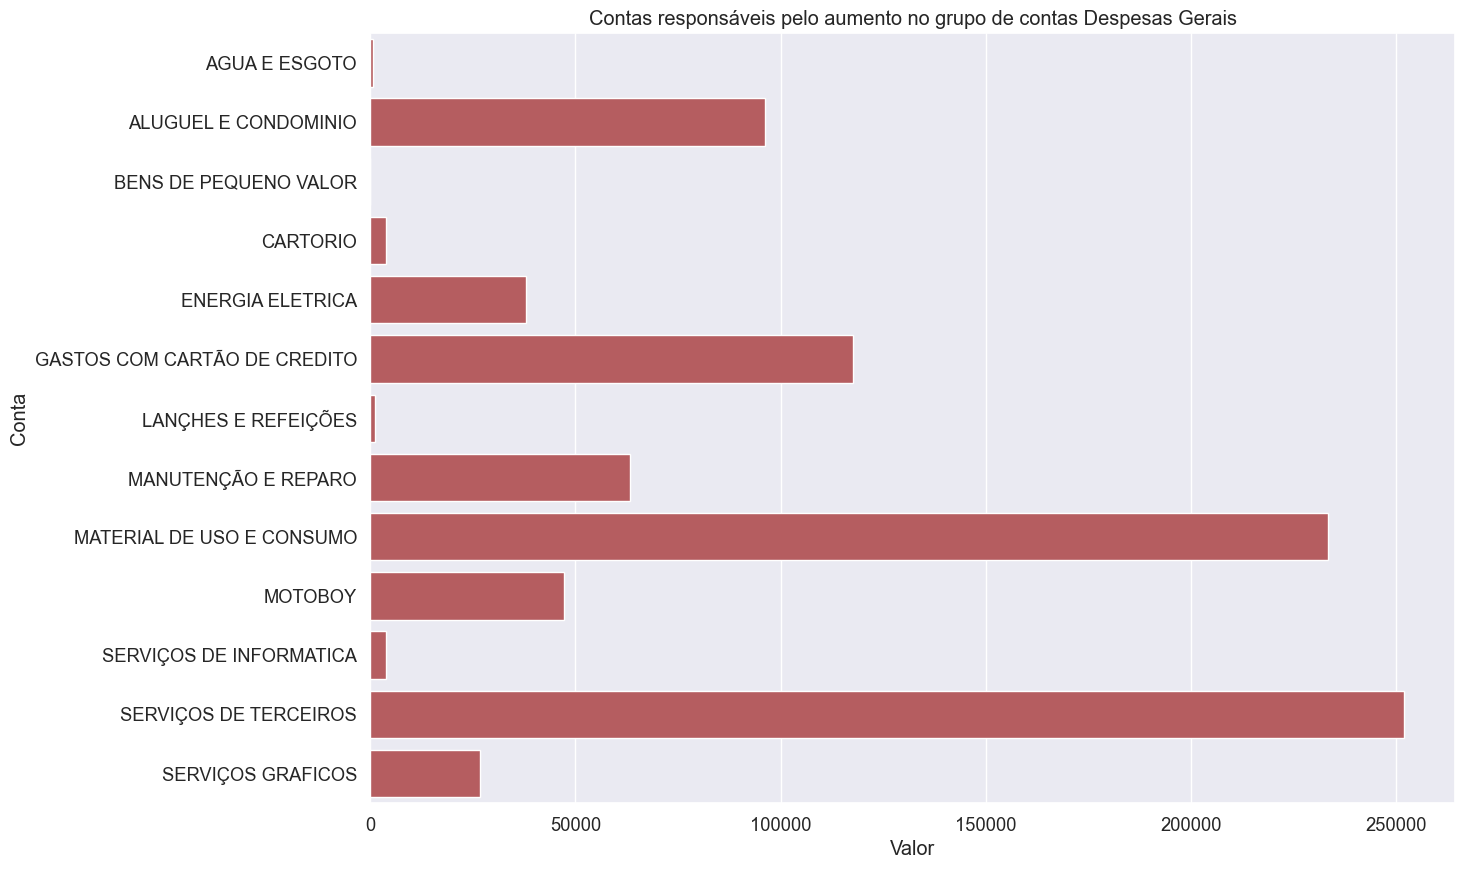

In [33]:
# Gráfico
df_contabil_ger2 = df_contabil_ger.rename(columns={'Crescimento/Redução':'Cresc_Red'},inplace=True)
df_contabil_ger2 = df_contabil_ger.query('Cresc_Red >0').reset_index()
sns.set(font_scale = 1.2)
plt.figure(figsize = (14,10))
sns.barplot(x = df_contabil_ger2['Cresc_Red'], y = df_contabil_ger2['Conta'], color = 'r')
plt.title("Contas responsáveis pelo aumento no grupo de contas Despesas Gerais")
plt.xlabel('Valor')
plt.show()